#Text Classification: TF-IDF

L'approccio TF-IDF (Term Frequency-Inverse Document Frequency) è una tecnica fondamentale per la classificazione del testo nel campo del Natural Language Processing (NLP). Questa tecnica valuta l'importanza delle parole all'interno di un documento rispetto a un corpus più ampio.

TF-IDF combina due principali concetti: la Term Frequency (TF) e l'Inverse Document Frequency (IDF). La TF misura la frequenza di una parola in un documento specifico, mentre l'IDF misura l'importanza di una parola rispetto all'intero corpus. Le parole che sono comuni in un documento ma rare nell'intero corpus hanno un punteggio IDF più alto, indicando la loro importanza.

Le caratteristiche TF-IDF vengono calcolate per ciascun documento nel corpus e utilizzate come input per modelli di machine learning come la regressione logistica o i classificatori bayesiani. Durante l'addestramento, questi modelli imparano a riconoscere i pattern nei dati TF-IDF associati a diverse categorie di classificazione.

Una volta addestrato, il modello può essere utilizzato per classificare nuovi documenti, utilizzando le caratteristiche TF-IDF estratte da essi e assegnando loro le categorie corrispondenti.

In questo modo, TF-IDF offre un metodo efficace per estrarre e rappresentare le caratteristiche rilevanti del testo, consentendo ai modelli di classificazione del testo di apprendere e generalizzare dai dati di addestramento per effettuare previsioni accurate su nuovi dati di testo.

##Installazione/Importazione delle dependencies

In [ ]:
!pip install cleantext

In [81]:
# Utilities
import pandas as pd
import numpy as np
import re

# Strumenti NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Costruzione e addestramento modello
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Plot
import matplotlib.pyplot as plt

# Drive
from google.colab import drive

In [ ]:
nltk.download('all')

##Caricamento e studio preliminare del dataset

In [83]:
# Monta la cartella di Google Drive
drive.mount('/content/drive')

# Lettura dei dati dal file
my_path = "/content/drive/MyDrive/Lavoro/Test/Text Classification/Datasets"
data = pd.read_csv(f"{my_path}/spam_text_messages.csv", dtype = "category")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Il dataset è costituito da una colonna ***Message*** che contiene il corpo dei messaggi e da una colonna ***Category*** che distingue i messaggi di spam (negativo) e di ham (positivo).

In [84]:
# Aumenta la lunghezza del print del dataframe fino a 200 caratteri
pd.set_option('display.max_colwidth', 200)

data[:10]

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"
5,spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv"
6,ham,Even my brother is not like to speak with me. They treat me like aids patent.
7,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
8,spam,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
9,spam,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030


Come sono distribuiti i messaggi di ham e jam?

In [85]:
values = data['Category'].value_counts()

# Distribuzione messaggi
print(values)

# Messaggi ham
print(f"\nHam: {round(values[0] / (values[0] + values[1]) * 100, 1)} %")

# Messaggi spam
print(f"Spam: {round(values[1] / (values[0] + values[1]) * 100, 1)} %")

# Totale messaggi
print(f"\nMessaggi: {values[0] + values[1]}")

ham     4825
spam     747
Name: Category, dtype: int64

Ham: 86.6 %
Spam: 13.4 %

Messaggi: 5572


C'è qualche valore nullo all'interno del dataset?

In [86]:
data.isnull().sum()

Category    0
Message     0
dtype: int64

Rimuovi eventuali valori nulli

In [87]:
data = data.dropna()

##Pulizia del testo

In [88]:
messages_original = data['Message']

Definamo la funzione che applica il preprocessing al corpo dei messaggi

In [89]:
def preprocess_text(text):

    # Inizializzo corpus
    corpus = []

    # Istanzio lemmatizzatore
    lemmatizer = WordNetLemmatizer()

    for i in range(len(text)):

        # Rimuovi caratteri non alfabetici
        r = re.sub('[^a-zA-Z]', ' ', text[i])

        # Applico lowercasing
        r = r.lower()

        # Applico splitting
        r = r.split()

        # Filtra le stopwords
        r = [word for word in r if word not in stopwords.words('english')]

        # Applica lemmatizzazione
        r = [lemmatizer.lemmatize(word) for word in r]

        # Riunisci parole processate
        r = ' '.join(r)

        corpus.append(r)

    return corpus

Applichiamo la pulizia del testo

In [90]:
messages_processed = preprocess_text(messages_original)

Confrontiamo i messaggi originali con quelli processati

In [91]:
pd.DataFrame(messages_original[:7])

,Message
0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,Ok lar... Joking wif u oni...
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,U dun say so early hor... U c already then say...
4,"Nah I don't think he goes to usf, he lives around here though"
5,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv"
6,Even my brother is not like to speak with me. They treat me like aids patent.


In [92]:
pd.DataFrame(messages_processed[:7])

,0
0,go jurong point crazy available bugis n great world la e buffet cine got amore wat
1,ok lar joking wif u oni
2,free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply
3,u dun say early hor u c already say
4,nah think go usf life around though
5,freemsg hey darling week word back like fun still tb ok xxx std chgs send rcv
6,even brother like speak treat like aid patent


Aggiorniamo la colonna Message del dataset con i valori puliti

In [93]:
data['Message'] = messages_processed
data.head()

,Category,Message
0,ham,go jurong point crazy available bugis n great world la e buffet cine got amore wat
1,ham,ok lar joking wif u oni
2,spam,free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply
3,ham,u dun say early hor u c already say
4,ham,nah think go usf life around though


##Creazione set di Train e Test

In [94]:
X = data['Message']
y = data['Category']

# Applichiamo uno splitting 80/20 tra istanze di train e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

# Controlliamo le shapes delle istanze
print(f"Training Data :'{X_train.shape}")
print(f"Testing Data : '{X_test.shape}")

Training Data :'(4457,)
Testing Data : '(1115,)


##Feature Extraction

In [95]:
# Convertitore
cv = CountVectorizer()

# Trasformazione testo in rappresentazione numerica per l'addestramento
X_train_cv = cv.fit_transform(X_train)

# Shape X_train_cv
X_train_cv.shape

(4457, 6290)

##Modellazione training ed evaluation

In [96]:
# Modello di regressione
lr = LogisticRegression()

# Addestramento modello di regressione
lr.fit(X_train_cv, y_train)

LogisticRegression()

In [97]:
# Trasformazione dei dati di test
X_test_cv = cv.transform(X_test)

In [98]:
# Esegui predizioni con modello di regressione logistica
predictions = lr.predict(X_test_cv)

# Visualizza predizioni
predictions

array(['ham', 'ham', 'ham', ..., 'ham', 'ham', 'ham'], dtype=object)

Andiamo a valutare le prestazioni del modello

In [99]:
# Calcola matrice di confusione
conf_matrix = pd.DataFrame(metrics.confusion_matrix(y_test,predictions), index=['ham','spam'], columns=['ham','spam'])

In [127]:
# Definizione valori della matrice di confusione
TP = conf_matrix['ham']['ham']
FP = conf_matrix['ham']['spam']
FN = conf_matrix['spam']['ham']
TN = conf_matrix['spam']['spam']

# Calcolo metriche di performance
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)

Creiamo un grafico delle misure di perfromance

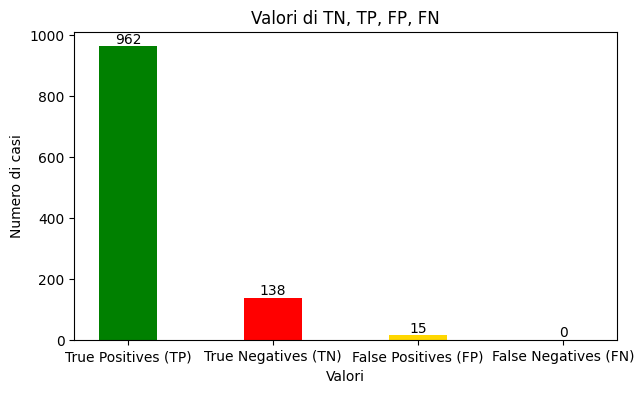

In [129]:
labels = ['True Positives (TP)', 'True Negatives (TN)',  'False Positives (FP)', 'False Negatives (FN)']
values = [TP, TN, FP, FN]
colors = ['green', 'red', 'gold', 'orange']

# Imposta dimensione plot
plt.figure(figsize=(7, 4))

# Configura barre
plt.bar(labels, values, color=colors, width=.4)

# Aggiungi il valore sopra ogni barra
for i in range(len(labels)):
    plt.text(i, values[i], str(values[i]), ha='center', va='bottom')

# Configura
plt.title('Valori di TN, TP, FP, FN')
plt.xlabel('Valori')
plt.ylabel('Numero di casi')

# Mostra il plot
plt.show()

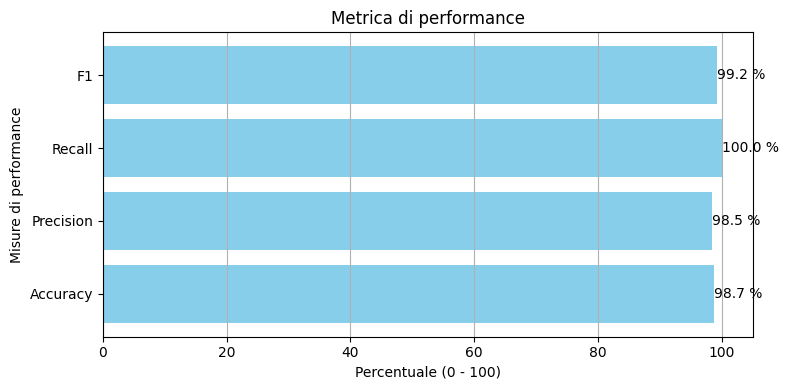

In [123]:
labels = ['Accuracy', 'Precision',  'Recall', 'F1']
values = [round(accuracy, 3) * 100,
          round(precision, 3) * 100,
          round(recall, 3) * 100,
          round(f1, 3) * 100
         ]

# Imposta dimensione plot
plt.figure(figsize=(8, 4))

# Aggiungi il valore sopra ogni barra
plt.barh(labels, values, color='skyblue')

# Aggiungi il valore sopra ogni barra
for i in range(len(labels)):
    plt.text(values[i], i, str(values[i]) + " %", ha='left', va='center')

# Configura plot
plt.title('Metrica di performance')
plt.xlabel('Percentuale (0 - 100)')
plt.ylabel('Misure di performance')
plt.grid(axis='x')
plt.tight_layout()

# Mostra il plot
plt.show()